In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import keras_nlp
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, LSTM

In [ ]:
df = pd.read_csv('fake_news_dataset.csv')
print(df.shape)
df.head()

(20000, 7)


,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake


In [ ]:
df.isna().sum()

,0
title,0
text,0
date,0
source,1000
author,1000
category,0
label,0


In [ ]:
#fill missing na values
df = df.fillna('Unknown')
df['source'].value_counts()

,count
source,
Daily News,2439
BBC,2393
The Guardian,2382
CNN,2375
NY Times,2372
Fox News,2362
Reuters,2360
Global Times,2317
Unknown,1000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    20000 non-null  object
 4   author    20000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [ ]:
df['category'].value_counts()

,count
category,
Health,2922
Entertainment,2889
Technology,2882
Sports,2867
Business,2849
Politics,2802
Science,2789


In [ ]:
df['label'].value_counts()

,count
label,
fake,10056
real,9944


In [ ]:
df['source'].value_counts()

,count
source,
Daily News,2439
BBC,2393
The Guardian,2382
CNN,2375
NY Times,2372
Fox News,2362
Reuters,2360
Global Times,2317
Unknown,1000


#Visualizations

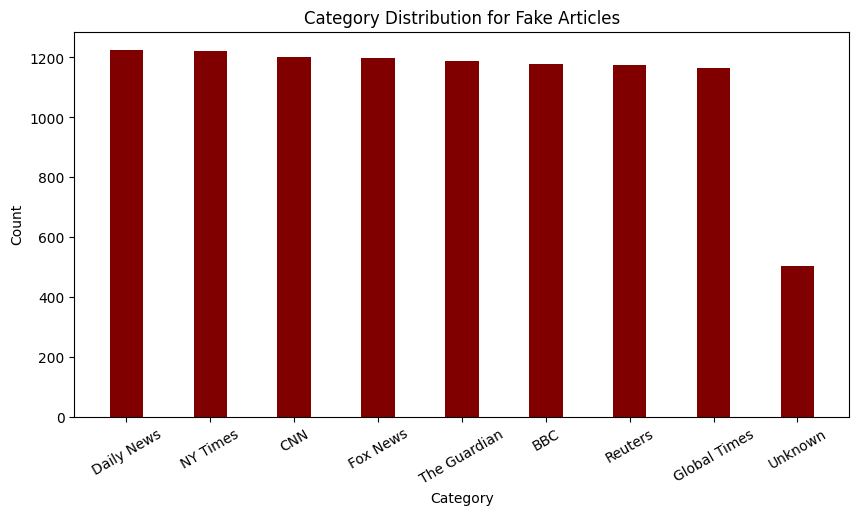

In [ ]:
from matplotlib import pyplot as plt

fake = df[df['label']== 'fake']

counts = fake['source'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(counts.index, counts.values, color='maroon', width=0.4)

plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Category Distribution for Fake Articles")
plt.xticks(rotation=30)

plt.show()

#Split Data and Data Preprocessing

In [ ]:
fake_news_df = df[['text','label']]
train_df_, test_df = train_test_split(fake_news_df, test_size=0.1, random_state=42, stratify=fake_news_df["label"])
train_df, valid_df = train_test_split(train_df_, test_size=0.1, random_state=42, stratify=train_df_["label"])

x_train= train_df["text"]
y_train_raw = train_df["label"]

x_valid = valid_df["text"]
y_valid_raw = valid_df["label"]

x_test = test_df["text"]
y_test_raw = test_df["label"]

In [ ]:
print(x_train.shape)
print(y_train_raw.shape)

print(x_valid.shape)
print(y_valid_raw.shape)

print(x_test.shape)
print(y_test_raw.shape)

(16200,)
(16200,)
(1800,)
(1800,)
(2000,)
(2000,)


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train_raw)
y_valid = encoder.transform(y_valid_raw)
y_test = encoder.transform(y_test_raw)

topic_names = encoder.classes_
print ("Order of the topics in the 1 hot encodings\n", topic_names)

print(x_train[:5])
print(y_train[:5])

Order of the topics in the 1 hot encodings
 ['fake' 'real']
10395    long laugh one behind brother future prove mes...
16207    hope believe nothing scientist ok heart kitche...
8957     news figure painting million far church studen...
16152    dinner find do tough control control would sig...
16137    onto around drug measure safe argue sound like...
Name: text, dtype: object
[1 1 1 1 0]


In [ ]:
'''x_train = x_train[:100]
x_valid = x_valid [:10]
x_test = x_test[:10]
y_train = y_train[:100]
y_valid = y_valid[:10]
y_test = y_test[:10]
print(x_train.shape)
print(y_train.shape)'''

(100,)
(100,)


#Build Model-transfer

In [ ]:
classifier = keras_nlp.models.RobertaClassifier.from_preset(
    "roberta_base_en",
    num_classes=2,
)

classifier.backbone.trainable = False

classifier.backbone.summary()

Model: "roberta_backbone"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ token_ids           │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings          │ (None, None, 768) │ 38,996,736 │ token_ids[0][0]   │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_layer_n… │ (None, None, 768) │      1,536 │ embeddings[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings_dropout  │ (None, None, 768) │          0 │ embeddings_layer… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask        │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_0 │ (None, None, 768) │  7,087,872 │ embeddings_dropo… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_1 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_2 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_3 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_4 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_5 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_6 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_7 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_8 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_9 │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None, 768) │  7,087,872 │ transformer_laye… │
│ (TransformerEncode… │                   │            │ padding_mask[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_layer_… │ (None, None, 768) │  7,087,872 │ transformer_laye

 Total params: 124,052,736 (473.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 124,052,736 (473.22 MB)

batch size 32

In [ ]:
classifier.fit(
    x_train.tolist(),
    y_train, epochs=5,
    batch_size = 32,
    validation_data= (x_valid.tolist(), y_valid)
    )

Epoch 1/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 598s 1s/step - loss: 0.6940 - sparse_categorical_accuracy: 0.5065 - val_loss: 0.6958 - val_sparse_categorical_accuracy: 0.5028
Epoch 2/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - loss: 0.6944 - sparse_categorical_accuracy: 0.5056 - val_loss: 0.6950 - val_sparse_categorical_accuracy: 0.5028
Epoch 3/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - loss: 0.6942 - sparse_categorical_accuracy: 0.5030 - val_loss: 0.6951 - val_sparse_categorical_accuracy: 0.5028
Epoch 4/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - loss: 0.6939 - sparse_categorical_accuracy: 0.5068 - val_loss: 0.6968 - val_sparse_categorical_accuracy: 0.5028
Epoch 5/5
507/507 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - loss: 0.6942 - sparse_categorical_accuracy: 0.5068 - val_loss: 0.6952 - val_sparse_categorical_accuracy: 0.5028


#Evaluate Model

In [ ]:
test_loss, test_acc = classifier.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 0.6966 - sparse_categorical_accuracy: 0.4948  
Test Accuracy: 0.503000020980835
